# Lab 03: Spatial image processing

The purpose of this lab is to practice preprocessing needed on T1 images images and spatial normalization. Although spatial normalization is needed for the functional images as well, we will first get used to the concept with structural images.

## Preparation
* import python tools for plotting 3D images
* copy basic T1 images from our osfshare for easy access to the files for this lab

In [1]:
from nilearn import plotting
from nilearn import image

In [22]:
%%bash
# Copy files from lab 01 for easier work with them here
# Name them generic names for ease of seeing how the command line programs work
cp ../01-Lab/osfshare/sub-97-T1w_brain.nii.gz my_T1_brain.nii.gz
cp ../01-Lab/osfshare/sub-97-T1w_defaced.nii.gz my_T1.nii.gz

### How did we get that "brain" image with the skull stripped  again?
* FSL provides a tool called _bet_ which stands for _brain extraction tool_. See the [bet user manual here](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET/UserGuide). 
* It requires only the brain image with skull as input and has relatively few options. Performance is generally OK, but it is common to need to tweak the -f and -g options. 
* If you want to get serious about getting a great brain mask (e.g., your brains have many individual differences in shape due to atrophy), you should look to [ANTs](http://stnava.github.io/ANTs/). Here is an [example](https://dpaniukov.github.io/2016/06/06/brain-extraction-with-ants.html) of using their brain extraction tool
* *Good brain extraction is essential to good registration*. If you see poor registration of your images later on then one place to start trouble-shooting is to look at the quality of your brain extraction by comparing the brain mask (what the program thinks is brain) to the image with the skull (did the program include non-brain tissues in the mask OR chop off part of the brain?)
    - Never assume BET worked great, always check!!

In [23]:
# refresher, are my images here?
!ls

fast.log		      my_T1_brain_pveseg.nii.gz
MNI152_T1_2mm_brain.nii.gz    my_T1_brain_restore.nii.gz
my_bold.nii.gz		      my_T1_brain_seg_0.nii.gz
my_T1_brain_bias.nii.gz       my_T1_brain_seg_1.nii.gz
my_T1_brain_mixeltype.nii.gz  my_T1_brain_seg_2.nii.gz
my_T1_brain.nii.gz	      my_T1_brain_seg.nii.gz
my_T1_brain_pve_0.nii.gz      my_T1.nii.gz
my_T1_brain_pve_1.nii.gz      SpatialImageProcessing.ipynb
my_T1_brain_pve_2.nii.gz


## T1 image bias correction and image segmentation
* FSL provides a nice tool called [FAST](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FAST) that combines bias field correction (see Handbook p56) and tissue segmentation
* You will need to input a T1 image of the brain without skull, so brain extraction should be run before-hand

In [5]:
# Look at usage
!fast


Part of FSL (build 509)
FAST 
Copyright(c) 2004-2012, University of Oxford

Usage: 
fast [options] file(s)

Optional arguments (You may optionally specify one or more of):
	-n,--class	number of tissue-type classes; default=3
	-I,--iter	number of main-loop iterations during bias-field removal; default=4
	-l,--lowpass	bias field smoothing extent (FWHM) in mm; default=20
	-t,--type	type of image 1=T1, 2=T2, 3=PD; default=T1
	-f,--fHard	initial segmentation spatial smoothness (during bias field estimation); default=0.02
	-g,--segments	outputs a separate binary image for each tissue type
	-a <standard2input.mat> initialise using priors; you must supply a FLIRT transform
	-A <prior1> <prior2> <prior3>    alternative prior images
	--nopve	turn off PVE (partial volume estimation)
	-b		output estimated bias field
	-B		output bias-corrected image
	-N,--nobias	do not remove bias field
	-S,--channels	number of input images (channels); default 1
	-o,--out	output basename
	-P,--Prior	use priors thr

In [7]:
%%bash
# example usage below
# running this should take ~10 minutes
fast -t 1 -n 3 -g -b -B -v -o my_T1_brain my_T1_brain.nii.gz > fast.log

In [ ]:
# Write out what these options are doing
# Verbose output can help with seeing under the hood and tracking the process

In [8]:
# Check outputs
!ls

fast.log		      my_T1_brain_pveseg.nii.gz
my_bold.nii.gz		      my_T1_brain_restore.nii.gz
my_T1_brain_bias.nii.gz       my_T1_brain_seg_0.nii.gz
my_T1_brain_mixeltype.nii.gz  my_T1_brain_seg_1.nii.gz
my_T1_brain.nii.gz	      my_T1_brain_seg_2.nii.gz
my_T1_brain_pve_0.nii.gz      my_T1_brain_seg.nii.gz
my_T1_brain_pve_1.nii.gz      SpatialImageProcessing.ipynb
my_T1_brain_pve_2.nii.gz


### Practice: 
* Use FSLview to open your T1 image with the "seg" images overlayed on top
* What do these images represent?

In [9]:
!fslview my_T1_brain.nii.gz my_T1_brain_seg_0.nii.gz my_T1_brain_seg_1.nii.gz my_T1_brain_seg_2.nii.gz

* The bias corrected image ends with "restore" - take a look and compare values in the view and by looking at their histograms

## Spatial registration
* Now let's walk through how to spatially align our high-resolution T1 image and our functional bold image to the MNI-152 standard template.

### Open MNI 152 template in FSLview
* Open standard > MNI152_T1_2mm_brain
* Where is origin?
* What does 2mm refer to in the file name?

In [17]:
%%bash
fslview

In [35]:
# Copy variants of MNI to our local directory for easy access
!cp /usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain.nii.gz ./MNI152_T1_2mm_brain.nii.gz
!cp /usr/share/fsl/5.0/data/standard/MNI152_T1_2mm.nii.gz ./MNI152_T1_2mm.nii.gz
!cp /usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain_mask_dil.nii.gz ./MNI152_T1_2mm_brain_mask_dil.nii.gz
!ls

fast.log			     my_T1_brain_pveseg.nii.gz
MNI152_T1_2mm_brain_mask_dil.nii.gz  my_T1_brain_restore.nii.gz
MNI152_T1_2mm_brain.nii.gz	     my_T1_brain_seg_0.nii.gz
MNI152_T1_2mm.nii.gz		     my_T1_brain_seg_1.nii.gz
my_bold.nii.gz			     my_T1_brain_seg_2.nii.gz
my_T1_brain_bias.nii.gz		     my_T1_brain_seg.nii.gz
my_T1_brain_mixeltype.nii.gz	     my_T1.nii.gz
my_T1_brain.nii.gz		     SpatialImageProcessing.ipynb
my_T1_brain_pve_0.nii.gz	     T1_2_MNI.mat
my_T1_brain_pve_1.nii.gz	     T1_2_MNI.nii.gz
my_T1_brain_pve_2.nii.gz


### Preliminary steps
Before registration it is nice if:
* Images are all in same orientation as MNI (such as RPI)
* If you want to do non-linear registration, FSL requires you have both the skulled and brain-extracted image available
* You may get better results if you have bias-field corrected image. We use our base images for the examples.  

### The core tools in FSL for registration are:
* [FLIRT](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FLIRT) for linear registration problems
    - FLIRT [user guide](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FLIRT/UserGuide#flirt) which includes examples
    - Notice in usage that *estimation* of the transformation and *application* of the transform are separate options
    - FLIRT can also be run with [BBR](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FLIRT_BBR) if your functional image has good gray matter/white matter contrast. BBR best run on the command-line using the epi_reg program.
* [FNIRT](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FNIRT) for non-linear registration 

### Registration of our T1 to the MNI 152 template

#### Step 1: Use FLIRT for estimation of linear transformation between T1 and MNI. Any linear transformation will be represented by a 4 x 4 affine matrix (the files that typically end in .mat)

In [25]:
# Look at GUI form of FLIRT and noted defaults
!fsl

In [42]:
%%bash
# Flirt to align T1 to MNI with an affine transformation, with defaults set on command line
# Note the back-slashes (\) are to tell bash to continue the command across a new line, which helps with readability
flirt -in my_T1_brain.nii.gz -ref MNI152_T1_2mm_brain.nii.gz \
-out T1_2_MNI_aff.nii.gz -omat T1_2_MNI.mat \
-cost corratio -dof 12 -searchrx -90 90 -searchry -90 90 -interp trilinear

In [43]:
!ls

fast.log			     my_T1_brain_seg_0.nii.gz
MNI152_T1_2mm_brain_mask_dil.nii.gz  my_T1_brain_seg_1.nii.gz
MNI152_T1_2mm_brain.nii.gz	     my_T1_brain_seg_2.nii.gz
MNI152_T1_2mm.nii.gz		     my_T1_brain_seg.nii.gz
my_bold.nii.gz			     my_T1.nii.gz
my_T1_brain_bias.nii.gz		     my_T1_to_MNI152_T1_2mm.log
my_T1_brain_mixeltype.nii.gz	     SpatialImageProcessing.ipynb
my_T1_brain.nii.gz		     T1_2_MNI_aff.nii.gz
my_T1_brain_pve_0.nii.gz	     T1_2_MNI_jac.nii.gz
my_T1_brain_pve_1.nii.gz	     T1_2_MNI.mat
my_T1_brain_pve_2.nii.gz	     T1_2_MNI.nii.gz
my_T1_brain_pveseg.nii.gz	     T1_2_MNI_warp.nii.gz
my_T1_brain_restore.nii.gz


In [39]:
# We can look at the affine matrix
!cat T1_2_MNI.mat

1.027140828  0.01351613128  -0.05340760123  -29.44468889  
0.006875459172  1.061489044  0.07578740997  -22.65620149  
0.05011516494  -0.132928273  1.149060008  -54.7449717  
0  0  0  1  


In [38]:
# We can see the separate components of the transformation with avscale
!avscale T1_2_MNI.mat

Rotation & Translation Matrix:
0.998789 -0.000547 -0.049185 -29.444689 
0.006686 0.992169 0.124724 -22.656201 
0.048732 -0.124902 0.990972 -54.744972 
0.000000 0.000000 0.000000 1.000000 

Scales (x,y,z) = 1.028386 1.069772 1.150765 

Skews (xy,xz,yz) = 0.013198 0.002746 -0.059349 

Average scaling = 1.08297

Determinant = 1.266
Left-Right orientation: preserved

Forward half transform =
1.013786 0.005743 -0.024875 -14.939754 
0.002617 1.032288 0.035307 -10.652573 
0.024823 -0.064549 1.072341 -26.543653 
0.000000 0.000000 0.000000 1.000000 

Backward half transform =
0.985833 -0.004081 0.024442 15.333411 
-0.002312 0.968356 -0.033250 9.398382 
-0.021511 0.055745 0.928557 24.919749 
0.000000 0.000000 0.000000 1.000000 



In [45]:
# Let's compare alignment for caudate and gyri
!fslview MNI152_T1_2mm_brain.nii.gz T1_2_MNI_aff.nii.gz

#### Step 2: Use FNIRT to estimate a more refined non-linear "warp field" to align structures more locally

In [33]:
!fnirt




Part of FSL (build 509)
fnirt

Usage: 
fnirt --ref=<some template> --in=<some image>
fnirt --ref=<some template> --in=<some image> --infwhm=8,4,2 --subsamp=4,2,1 --warpres=8,8,8

Compulsory arguments (You MUST set one or more of):
	--ref		name of reference image
	--in		name of input image

Optional arguments (You may optionally specify one or more of):
	--aff		name of file containing affine transform
	--inwarp	name of file containing initial non-linear warps
	--intin		name of file/files containing initial intensity mapping
	--cout		name of output file with field coefficients
	--iout		name of output image
	--fout		name of output file with field
	--jout		name of file for writing out the Jacobian of the field (for diagnostic or VBM purposes)
	--refout	name of file for writing out intensity modulated --ref (for diagnostic purposes)
	--intout	name of files for writing information pertaining to intensity mapping
	--logout	Name of log-file
	--config	Name of config file specifying command l

In [36]:
!ls

fast.log			     my_T1_brain_pveseg.nii.gz
MNI152_T1_2mm_brain_mask_dil.nii.gz  my_T1_brain_restore.nii.gz
MNI152_T1_2mm_brain.nii.gz	     my_T1_brain_seg_0.nii.gz
MNI152_T1_2mm.nii.gz		     my_T1_brain_seg_1.nii.gz
my_bold.nii.gz			     my_T1_brain_seg_2.nii.gz
my_T1_brain_bias.nii.gz		     my_T1_brain_seg.nii.gz
my_T1_brain_mixeltype.nii.gz	     my_T1.nii.gz
my_T1_brain.nii.gz		     SpatialImageProcessing.ipynb
my_T1_brain_pve_0.nii.gz	     T1_2_MNI.mat
my_T1_brain_pve_1.nii.gz	     T1_2_MNI.nii.gz
my_T1_brain_pve_2.nii.gz


In [37]:
%%bash
# FNIRT with default parameters
fnirt --iout=T1_2_MNI_head --in=my_T1 --aff=T1_2_MNI.mat \
--cout=T1_2_MNI_warp --iout=T1_2_MNI --jout=T1_2_MNI_jac \
--config=T1_2_MNI152_2mm \
--ref=MNI152_T1_2mm.nii.gz --refmask=MNI152_T1_2mm_brain_mask_dil.nii.gz \
--warpres=10,10,10

In [46]:
!ls

fast.log			     my_T1_brain_seg_0.nii.gz
MNI152_T1_2mm_brain_mask_dil.nii.gz  my_T1_brain_seg_1.nii.gz
MNI152_T1_2mm_brain.nii.gz	     my_T1_brain_seg_2.nii.gz
MNI152_T1_2mm.nii.gz		     my_T1_brain_seg.nii.gz
my_bold.nii.gz			     my_T1.nii.gz
my_T1_brain_bias.nii.gz		     my_T1_to_MNI152_T1_2mm.log
my_T1_brain_mixeltype.nii.gz	     SpatialImageProcessing.ipynb
my_T1_brain.nii.gz		     T1_2_MNI_aff.nii.gz
my_T1_brain_pve_0.nii.gz	     T1_2_MNI_jac.nii.gz
my_T1_brain_pve_1.nii.gz	     T1_2_MNI.mat
my_T1_brain_pve_2.nii.gz	     T1_2_MNI.nii.gz
my_T1_brain_pveseg.nii.gz	     T1_2_MNI_warp.nii.gz
my_T1_brain_restore.nii.gz


In [48]:
# Again compare alignment for caudate and gyri
!fslview MNI152_T1_2mm_brain.nii.gz T1_2_MNI.nii.gz

#### Step 3: Apply these transforms together to your T1 image

In [50]:
!applywarp

***************************************************
The following COMPULSORY options have not been set:
	-i,--in	filename of input image (to be warped)
	-r,--ref	filename for reference image
	-o,--out	filename for output (warped) image
***************************************************

Part of FSL (build 509)
applywarp 
Copyright(c) 2001, University of Oxford (Jesper Andersson)

Usage: 
applywarp -i invol -o outvol -r refvol -w warpvol
applywarp -i invol -o outvol -r refvol -w coefvol


Compulsory arguments (You MUST set one or more of):
	-i,--in	filename of input image (to be warped)
	-r,--ref	filename for reference image
	-o,--out	filename for output (warped) image

Optional arguments (You may optionally specify one or more of):
	-w,--warp	filename for warp/coefficient (volume)
	--abs		treat warp field as absolute: x' = w(x)
	--rel		treat warp field as relative: x' = x + w(x)
	-d,--datatype	Force output data type [char short int float double].
	-s,--super	intermediary supersampling

In [52]:
%%bash
applywarp -i my_T1_brain.nii.gz -r MNI152_T1_2mm_brain.nii.gz -o T1_2_MNI_nonlin.nii.gz -w T1_2_MNI_warp.nii.gz

In [60]:
!fslview MNI152_T1_2mm_brain.nii.gz T1_2_MNI_nonlin.nii.gz

In [56]:
!fslview T1_2_MNI_warp.nii.gz

#### Nilearn plotting tools allow you to easily plot co-registered images together with "edge" maps

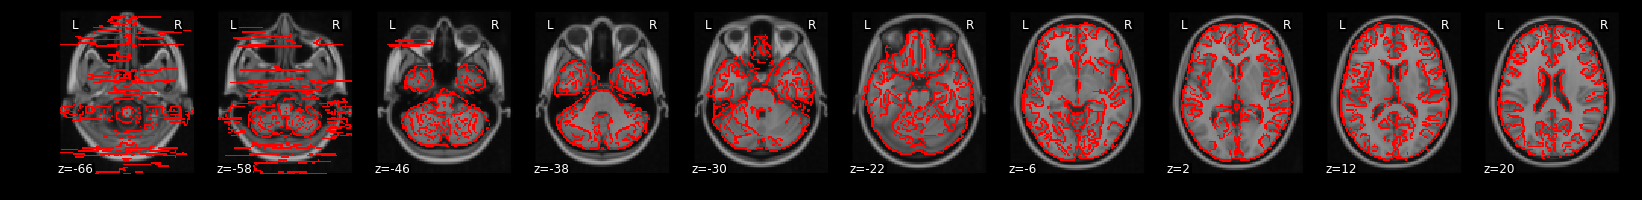

In [59]:
# Show our MNI as the base and our T1 as edges
mni="MNI152_T1_2mm.nii.gz"
img="T1_2_MNI_nonlin.nii.gz"
display=plotting.plot_anat(mni, display_mode="z",cut_coords=10)
display.add_edges(img)

# Practice problem

Download a new T1 image from OpenfMRI, and complete the following:
* Run brain extraction with bet 
* Run segmentation with FAST
* Register the T1 image to the MNI template using the same strategy as we did above
* Make a plot in your notebook showing the edges of the registered T1 image on top of the MNI standard brain

In [70]:
# We will download the T1 image from the first subject in this [dataset](https://openfmri.org/dataset/ds000101/).
# Code to download new image from Open fMRI
# The image will be named sub-01_T1w.nii.gz 
!wget -O sub-01_T1w.nii.gz https://s3.amazonaws.com/openneuro/ds000101/ds000101_R2.0.0/uncompressed/sub-01/anat/sub-01_T1w.nii.gz

--2018-02-10 14:25:49--  https://s3.amazonaws.com/openneuro/ds000101/ds000101_R2.0.0/uncompressed/sub-01/anat/sub-01_T1w.nii.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.129.245
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.129.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10783419 (10M) [binary/octet-stream]
Saving to: ‘sub-01_T1w.nii.gz’

sub-01_T1w.nii.gz   100%[=====================>]  10.28M  16.9MB/s   in 0.6s   

2018-02-10 14:25:50 (16.9 MB/s) - ‘sub-01_T1w.nii.gz’ saved [10783419/10783419]



In [78]:
%%bash
# Your code to run bet
# You should NOT need any additional parameters other than input and output, and specifcy that you want a mask
# Name your skull-stripped output sub-01_T1w_brain.nii.gz
bet sub-01_T1w.nii.gz sub-01_T1w_brain.nii.gz -m

In [83]:
%%bash
# Code to run FAST
fast -t 1 -n 3 -g -b -B -v -o sub-01_T1w_brain sub-01_T1w_brain.nii.gz > fast_sub01.log

Starting Single Image Segmentation
T1-weighted image
Imagesize : 176 x 256 x 256
Pixelsize : 1 x 1 x 1

1 4.94876
2 5.26786
3 5.6058
KMeans Iteration 0
KMeans Iteration 1
KMeans Iteration 2
KMeans Iteration 3
KMeans Iteration 4
KMeans Iteration 5
KMeans Iteration 6
KMeans Iteration 7
KMeans Iteration 8
KMeans Iteration 9
KMeans Iteration 10
KMeans Iteration 11
KMeans Iteration 12
KMeans Iteration 13
KMeans Iteration 14
KMeans Iteration 15
KMeans Iteration 16
KMeans Iteration 17
KMeans Iteration 18
Tanaka Iteration 0 bias field 4
Tanaka-inner-loop-iteration=0 MRFWeightsTotal=1.37973e+07 beta=0.02
Tanaka-inner-loop-iteration=1 MRFWeightsTotal=1.40007e+07 beta=0.02
Tanaka-inner-loop-iteration=2 MRFWeightsTotal=1.40063e+07 beta=0.02
Tanaka-inner-loop-iteration=3 MRFWeightsTotal=1.40065e+07 beta=0.02
Tanaka-inner-loop-iteration=4 MRFWeightsTotal=1.40065e+07 beta=0.02
 CLASS 1 MEAN 117.326 STDDEV 86.117 CLASS 2 MEAN 171.133 STDDEV 35.7301 CLASS 3 MEAN 287.513 STDDEV 37.602
Tanaka Iteration 1

In [85]:
%%bash
# Code estimate affine transform
# Name your image sub-01-T1_2_MNI_aff
# Name your affine transform sub-01-T1_2_MNI.mat
flirt -in sub-01_T1w_brain.nii.gz -ref MNI152_T1_2mm_brain.nii.gz \
-out sub-01-T1_2_MNI_aff.nii.gz -omat sub-01-T1_2_MNI.mat \
-cost corratio -dof 12 -searchrx -90 90 -searchry -90 90 -interp trilinear

In [86]:
%%bash
# Code to estimate transform with non-linear
fnirt --iout=sub-01_T1_2_MNI_head --in=sub-01_T1w.nii.gz --aff=sub-01-T1_2_MNI.mat \
--cout=sub-01_T1_2_MNI_warp --iout=sub-01_T1_2_MNI --jout=sub-01_T1_2_MNI_jac \
--config=T1_2_MNI152_2mm \
--ref=MNI152_T1_2mm.nii.gz --refmask=MNI152_T1_2mm_brain_mask_dil.nii.gz \
--warpres=10,10,10

In [89]:
%%bash
# Code to apply transforms to T1
# Name your output sub-01_T1_2_MNI_nonlin.nii.gz
applywarp -i sub-01_T1w_brain.nii.gz -r MNI152_T1_2mm_brain.nii.gz -o sub-01_T1_2_MNI_nonlin.nii.gz -w sub-01_T1_2_MNI_warp.nii.gz

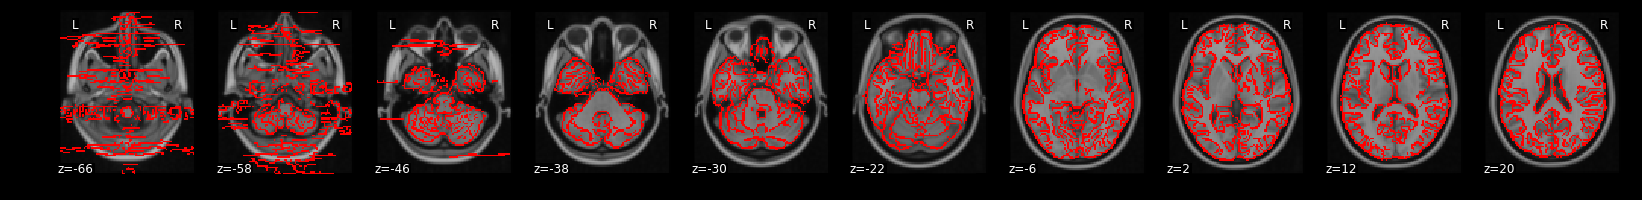

In [93]:
# Plot your images
mni="MNI152_T1_2mm.nii.gz"
img="sub-01_T1_2_MNI_nonlin.nii.gz"
display=plotting.plot_anat(mni, display_mode="z",cut_coords=10)
display.add_edges(img)